# Deep Q-Learning for Cliff-walking game

This notebook aims at familiarizing you with training, validating and testing a reinforncement learning agent using Deep Q-Learning. Here are the BASIC requirements:

- Initiate a Cliff-walking environment.
- Initiate an agent.
- Train the agent using <b>Deep Q-Learning</b>. You can implement the solution by using either a single policy network or a policy network and a target network.
- Print out the optimal policy, i.e., what is the best action to take at each stage.
- Test the optimal policy given by the Deep Q-Learning.

Cliff walking involves crossing a gridworld from start to goal while avoiding falling off a cliff. Each time step incurs -1 reward, unless the player stepped into the cliff, which incurs -100 reward.

![Cliff walking](https://gymnasium.farama.org/_images/cliff_walking.gif)

More details can be found at https://gymnasium.farama.org/environments/toy_text/cliff_walking/

### Install libraries and initiate a frozen lake map

In [19]:
# Install gymnasium game environment
!pip install gymnasium
!pip install gymnasium[toy-text]

In [20]:
# Load libraries
import gymnasium as gym
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
from keras.optimizers import Adam
from keras.layers import Dense, Dropout
from keras.models import Sequential
from collections import deque
import imageio
import pandas as pd
from IPython.display import Image

np.random.seed(22)

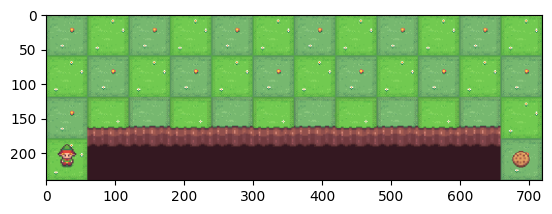

In [21]:
### Please do not change this code
# Initialize the environment\
env = gym.make('CliffWalking-v0', render_mode='rgb_array')
state_size = env.observation_space.n    # Number of states
action_size = env.action_space.n    # Number of actions of this game: four, 0: up, 1:right, 2: down, 3: left.
env.reset()    # Reset environment, i.e., set agent position to state 0
plt.imshow(env.render())    # Visualize environment map

### Solution

In [22]:
batch_size = 512
learning_rate = 0.001
epsilon_decay = 0.001
discount_factor = 0.9
train_episodes = 1001
max_steps = 151
update_steps = 8

In [23]:
# Define agent attibutes and methods
class Agent:
    def __init__(self, state_size, action_size):
        self.memory = deque(maxlen=2048)   # Deque is quick for append and pop operations from both the ends of the container.
        self.batch_size = batch_size    # Batch size of data samples for training policy (and target) network
        self.learning_rate = learning_rate    # Learning rate of
        self.epsilon = 1    # Start (max) value of epsilon
        self.min_eps = 0.01    # End (min) value of epsilon
        self.eps_decay = epsilon_decay     # Decay factor for decreasing epsilon over episodes
        self.gamma = discount_factor    # Discount factor
        self.state_size = state_size    # Number of states
        self.action_size =  action_size    # Number of possible actions the agent can take: four, 0: left, 1:down, 2: right, 3: up.
        self.episode = 0     # Agent current episode
        # self.epsilon_lst = []    # Track epsilon values over episodes
        self.max_steps = max_steps    # Maximum number of steps the agent can carry out in an episode
        self.train_episodes = train_episodes    # Number of training episodes
        self.update_steps = update_steps # After X times update for target network
        self.policy_network = self.build_model()    # Agent policy (and target model)
        self.target_network = self.build_model()
        self.update_target_network()    # Initialize the target model with the initial weights of the policy network


    # Build model architecture and compile it
    def build_model(self):
        model = Sequential()    # Initiate a simple sequential model
        model.add(Dense(512, input_dim=self.state_size, activation='relu'))    # Add a fully connected layer
        # model.add(Dense(256, input_dim=self.state_size, activation='relu'))
        # model.add(Dropout(0.2))
        model.add(Dense(self.action_size, activation='linear'))    # Add a fully connected layer connecting to the network output
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))    # Compile model with Mean Squared Error loss function
        return model

    def update_target_network(self):
        self.target_network.set_weights(self.policy_network.get_weights())

    # Add an eposide to agent's memory
    def add_memory(self, state, action, reward, new_state, terminated):
        self.memory.append((state, action, reward, new_state, terminated))    # Insert the value in its argument to the right end of the deque

    # Get action when agent is at a certain state
    def action(self, state):
        if np.random.rand() > self.epsilon:     # Epsilon starts at 1. rand > epsilon: exploit, rand <= epsilon: explore.
            return np.argmax(self.policy_network.predict(state, verbose=0))     # Take greedy action. Verbose=0 mutes output prediction log.
        return env.action_space.sample()    # Take a random action in the action space

    # Train policy (and target) network.
    def replay(self):
        minibatch = random.sample(self.memory, self.batch_size)
        minibatch_state = np.concatenate(np.array(minibatch, dtype=object)[:, 0], axis=0)
        minibatch_action = np.array(minibatch, dtype=object)[:, 1]
        minibatch_reward = np.array(minibatch, dtype=object)[:, 2]
        minibatch_new_state = np.concatenate(np.array(minibatch, dtype=object)[:, 3], axis=0)
        minibatch_terminated = np.array(minibatch, dtype=object)[:, 4]

        q_state = self.policy_network.predict(minibatch_state, verbose=0)
        q_new_state_target = self.target_network.predict(minibatch_new_state, verbose=0)
        q_action_optimal = np.add(minibatch_reward, self.gamma * np.amax(q_new_state_target, axis=1))

        for i in range(0, self.batch_size):
            q_state[i][minibatch_action[i]] = q_action_optimal[i]

        self.policy_network.fit(minibatch_state, q_state, epochs=1, verbose=0)
        self.update_target_network()

    # def sample_experiences(self):
    #     minibatch = random.sample(self.memory, self.batch_size)
    #     minibatch_state = np.concatenate(np.array(minibatch, dtype=object)[:, 0], axis=0)
    #     minibatch_action = np.array(minibatch, dtype=object)[:, 1]
    #     minibatch_reward = np.array(minibatch, dtype=object)[:, 2]
    #     minibatch_new_state = np.concatenate(np.array(minibatch, dtype=object)[:, 3], axis=0)
    #     minibatch_terminated = np.array(minibatch, dtype=object)[:, 4]

    #     return minibatch_state, minibatch_action, minibatch_reward, minibatch_new_state, minibatch_terminated

    # def replay(self):
    #     minibatch_state, minibatch_action, minibatch_reward, minibatch_new_state, minibatch_terminated = self.sample_experiences()

    #     # Calculate current state Q-values
    #     q_state = self.policy_network.predict(minibatch_state, verbose=0)

    #     # Calculate next state Q-values using the target model and choose actions using the policy model
    #     q_new_state_policy = self.policy_network.predict(minibatch_new_state, verbose=0)
    #     q_new_state_target = self.target_network.predict(minibatch_new_state, verbose=0)

    #     # Choose optimal actions for next state using the policy model
    #     optimal_actions = np.argmax(q_new_state_policy, axis=1)

    #     # Calculate Q-values for the optimal actions from the target model
    #     q_new_state_target_optimal = q_new_state_target[np.arange(self.batch_size), optimal_actions]

    #     # Calculate the target Q-values using Double DQN formula
    #     q_target = minibatch_reward + self.gamma * q_new_state_target_optimal * (1 - minibatch_terminated)

    #     # Update the Q-values for the selected actions in the current state Q-values
    #     for i in range(self.batch_size):
    #         q_state[i][minibatch_action[i]] = q_target[i]

    #     # Train the policy model with the updated Q-values
    #     self.policy_network.fit(minibatch_state, q_state, epochs=1, verbose=0)

    #     # Update the target model weights after a certain number of updates
    #     if self.episode % self.update_steps:
    #         self.update_target_network()


    # Save model
    def save_model(self, name):
        self.policy_network.save_weights(name)

    # Load model
    def load_model(self, name):
        self.policy_network.load_weights(name)

# Initialize a reinforcement learning agent
agent = Agent(state_size, action_size)
agent.policy_network.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 512)               25088     
                                                                 
 dense_13 (Dense)            (None, 4)                 2052      
                                                                 
Total params: 27,140
Trainable params: 27,140
Non-trainable params: 0
_________________________________________________________________


In [24]:
reward_episodes = []    # Track rewards over episodes
step_episodes = []    # Track number of steps (in each episode until termination) over episodes
epsilon_episodes = []    # Track epsilon values over episodes


for episode in range(agent.train_episodes + 1):
    agent.episode = episode    # Set agent's current episode
    state = env.reset()    # Reset environment, i.e., agent position is set to state 0
    state_arr = np.zeros(agent.state_size)    # Initialze current state array, e.g., [0. 0. 0. 0. 0. 0. 0. 0. 0.]
    state_arr[state[0]] = 1    # Set the agent position in the current state array, i.e., [[1. 0. 0. 0. 0. 0. 0. 0. 0.]]
    state_arr = np.reshape(state_arr, [1, agent.state_size])    # Reshape array
    reward = 0
    terminated = False    # Initialize terminated to False

    img_lst = [env.render()]    # Initialize list to store visualization frames
    for step in range(agent.max_steps):
      # 0: up, 1:right, 2: down, 3: left.
        action = agent.action(state_arr)
        new_state, new_reward, terminated, info, _ = env.step(action)     # Terminated: whether a terminal state is reached after taking the action. Ref: https://www.gymlibrary.dev/api/core/#gym.Env.step

        if new_reward == -100:
            reward += new_reward
            terminated = True
        else:
            reward -= new_reward

        if terminated == True and reward > 0:
            reward = 5 * (agent.max_steps - reward)
            if len(img_lst)>1:
               imageio.mimsave(animation_file, img_lst, format='GIF', duration=0.5)

        if step == agent.max_steps - 1:
            reward = -100 + int(agent.max_steps/2)

        new_state_arr = np.zeros(agent.state_size)    # Initialze new state array, e.g., [[0. 0. 0. 0. 0. 0. 0. 0. 0.]]
        new_state_arr[new_state] = 1    # Set the agent position in the new state array, after taking the action, e.g., [[0. 1. 0. 0. 0. 0. 0. 0. 0.]]
        new_state_arr = np.reshape(new_state_arr, [1, agent.state_size])    # Reshape array
        agent.add_memory(state_arr, action, reward, new_state_arr, terminated)    # Add current step to agent's memory
        state_arr = new_state_arr    # New state becomes state

        # Render map imgage for visualization every K episodes
        if agent.episode % 50 == 0:
            animation_file = "training_episode_" + str(agent.episode) + "_steps_" + str(step) + ".gif"
            img = env.render()    # Render current environment image
            img_lst.append(img)    # Append environment images to make animation

        if terminated:    # if agent reaches Goal
            break    # End episode

    print("Episode: " + str(agent.episode) + ", Steps: " + str(step) + ", epsilon: " + str(round(agent.epsilon,2)) + ", Reward: " + str(reward))
    reward_episodes.append(reward)    # Add reward to list for tracking purpose
    step_episodes.append(step)    # Add step to list for tracking purpose
    epsilon_episodes.append(agent.epsilon)    # Add epsilon to list for tracking purpose

    ### Update epsilon value which is the ratio of exploitation and exploration
    if agent.epsilon < agent.min_eps:
        agent.epsilon = agent.min_eps    # Set the minimum value of epsilon so that there is always a chance for exploration.
    else:
        agent.epsilon = np.exp(-agent.eps_decay*agent.episode)     # Decrease exploration / Increase exploitation overtime as the agent knows more about the environment

    ### If enough experiences collected in the memory, use them for training
    if len(agent.memory) > agent.batch_size:
        agent.replay()

    ## Update weight for target network
    if episode % agent.update_steps:
        agent.update_target_network()

    ### Write animation of the training episode (n*K)th
    if len(img_lst)>1:
        imageio.mimsave(animation_file, img_lst, format='GIF', duration=0.5)

print('Average success rate of training episodes: ', round(np.mean(reward_episodes),2))
agent.save_model('model_' + str(agent.episode))    # Save model

Episode: 0, Steps: 40, epsilon: 1, Reward: -60
Episode: 1, Steps: 4, epsilon: 1.0, Reward: -96
Episode: 2, Steps: 3, epsilon: 1.0, Reward: -97
Episode: 3, Steps: 3, epsilon: 1.0, Reward: -97
Episode: 4, Steps: 0, epsilon: 1.0, Reward: -100
Episode: 5, Steps: 1, epsilon: 1.0, Reward: -99
Episode: 6, Steps: 0, epsilon: 1.0, Reward: -100
Episode: 7, Steps: 1, epsilon: 0.99, Reward: -99
Episode: 8, Steps: 0, epsilon: 0.99, Reward: -100
Episode: 9, Steps: 2, epsilon: 0.99, Reward: -98
Episode: 10, Steps: 17, epsilon: 0.99, Reward: -83
Episode: 11, Steps: 41, epsilon: 0.99, Reward: -59
Episode: 12, Steps: 8, epsilon: 0.99, Reward: -92
Episode: 13, Steps: 1, epsilon: 0.99, Reward: -99
Episode: 14, Steps: 2, epsilon: 0.99, Reward: -98
Episode: 15, Steps: 12, epsilon: 0.99, Reward: -88
Episode: 16, Steps: 3, epsilon: 0.99, Reward: -97
Episode: 17, Steps: 26, epsilon: 0.98, Reward: -74
Episode: 18, Steps: 44, epsilon: 0.98, Reward: -56
Episode: 19, Steps: 51, epsilon: 0.98, Reward: -49
Episode: 

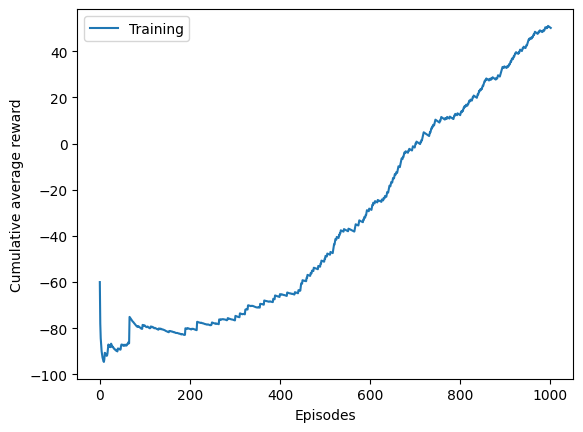

In [28]:
# Plot cumulative average reward (or success rate) of the training phase.
# This shows how well the agent performs in the training phase.
df_reward_episodes = pd.DataFrame(reward_episodes)
cumulative_average_rewards = df_reward_episodes.expanding().mean()
plt.plot(cumulative_average_rewards)
plt.ylabel('Cumulative average reward')
plt.xlabel('Episodes')
plt.legend(['Training'], loc='upper left')
matplotlib.rcParams.update({'font.size': 10})
plt.show()

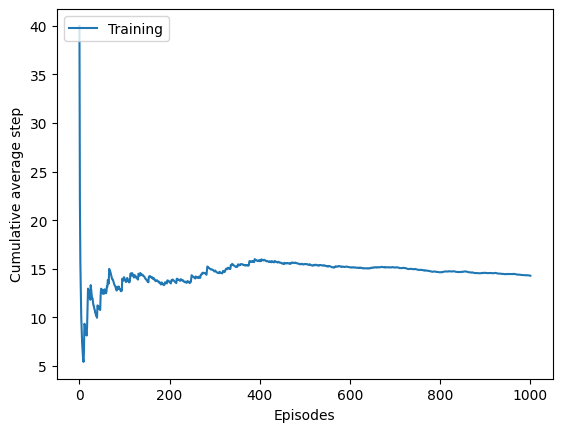

In [29]:
# Plot cumulative average steps of the training phase.
# This shows how well the agent performs in the training phase.
df_step_episodes = pd.DataFrame(step_episodes)
cumulative_average_steps = df_step_episodes.expanding().mean()
plt.plot(cumulative_average_steps)
plt.ylabel('Cumulative average step')
plt.xlabel('Episodes')
plt.legend(['Training'], loc='upper left')
matplotlib.rcParams.update({'font.size': 10})
plt.show()

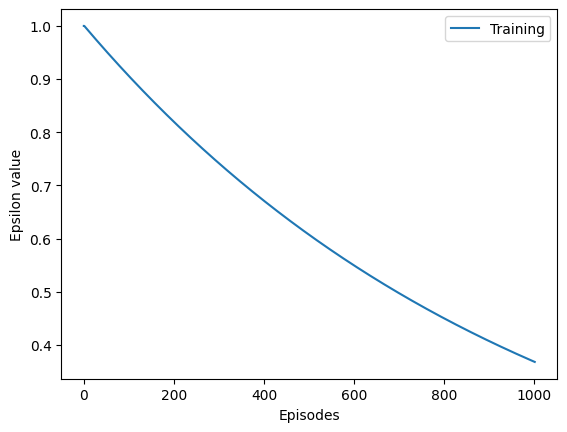

In [30]:
# Plot epsilon values over episodes
plt.plot(epsilon_episodes)
plt.ylabel('Epsilon value')
plt.xlabel('Episodes')
plt.legend(['Training'], loc='upper right')
matplotlib.rcParams.update({'font.size': 10})
plt.show()

In [25]:
# Print the optimal policy, i.e., at each state what is the best action to take.
for state_index in range(agent.state_size):
    state_arr=np.zeros(agent.state_size)    # Initialize state array, e.g., [[0. 0. 0. 0. 0. 0. 0. 0. 0.]]
    state_arr[state_index] = 1    # Set the agent position as if it is currently at each of the state
    state_arr= np.reshape(state_arr, [1, agent.state_size])    # Reshape state array
    q_values = agent.policy_network.predict(state_arr, verbose=0)    # Get Q-values of all actions of the current state
    best_action = np.argmax(q_values)    # # Get max-Q-value action, i.e., best action to take
    print("State " + str(state_index) + ", Best action: " + str(best_action))

State 0, Best action: 1
State 1, Best action: 1
State 2, Best action: 1
State 3, Best action: 1
State 4, Best action: 1
State 5, Best action: 1
State 6, Best action: 1
State 7, Best action: 1
State 8, Best action: 1
State 9, Best action: 1
State 10, Best action: 2
State 11, Best action: 2
State 12, Best action: 1
State 13, Best action: 1
State 14, Best action: 1
State 15, Best action: 1
State 16, Best action: 1
State 17, Best action: 1
State 18, Best action: 1
State 19, Best action: 1
State 20, Best action: 1
State 21, Best action: 1
State 22, Best action: 1
State 23, Best action: 2
State 24, Best action: 1
State 25, Best action: 1
State 26, Best action: 1
State 27, Best action: 1
State 28, Best action: 1
State 29, Best action: 1
State 30, Best action: 1
State 31, Best action: 1
State 32, Best action: 1
State 33, Best action: 1
State 34, Best action: 1
State 35, Best action: 2
State 36, Best action: 0
State 37, Best action: 1
State 38, Best action: 1
State 39, Best action: 1
State 40, 

In [26]:
# Load the saved agent model.
# agent.load_model('model_500')    # Uncomment this line if you want to load a saved model from file

# Test an episode
state = env.reset()    # Reset environment, i.e., agent position is set to state 0
state_arr = np.zeros(agent.state_size)    # Initialze current state array, e.g., [0. 0. 0. 0. 0. 0. 0. 0. 0.]
state_arr[state[0]] = 1    # Set the agent position in the current state array, i.e., [1. 0. 0. 0. 0. 0. 0. 0. 0.]
state_arr = np.reshape(state_arr, [1, agent.state_size])    # Reshape array, e.g., [[1. 0. 0. 0. 0. 0. 0. 0. 0.]]
terminated = False    # Initialize terminated to False
img_lst = [env.render()]    # Initialize list to store visualization frames
for step in range(agent.max_steps):
    q_values = agent.policy_network.predict(state_arr, verbose=0)    # Get Q-values of all actions of the current state
    best_action = np.argmax(q_values)    # Get max-Q-value action, i.e., best action to take
    new_state, reward, terminated, info, _ = env.step(best_action)    # Perform the best action, get return from environment
    new_state_arr = np.zeros(agent.state_size)    # Initialze new state array, e.g., [0. 0. 0. 0. 0. 0. 0. 0. 0.]
    new_state_arr[new_state] = 1    # Set the agent position in the new state array, after taking the action, e.g., [0. 1. 0. 0. 0. 0. 0. 0. 0.]
    new_state_arr = np.reshape(new_state_arr, [1, agent.state_size])    # Reshape array, e.g., [[0. 1. 0. 0. 0. 0. 0. 0. 0.]]
    print("Current state: " + str(np.argmax(state_arr)) + ", Action: " + str(best_action) + ", New state: " + str(np.argmax(new_state_arr)))
    state_arr = new_state_arr    # New state becomes state

    img = env.render()    # Render current environment image
    img_lst.append(img)    # Append environment images to make animation

    if terminated:    # If agent reaches Goal or Hole
        break    # End episode

print("Reward: " + str(reward))    # Print reward of the test episode
imageio.mimsave('test.gif', img_lst, format='GIF', duration=0.5)

Current state: 36, Action: 0, New state: 24
Current state: 24, Action: 1, New state: 25
Current state: 25, Action: 1, New state: 26
Current state: 26, Action: 1, New state: 27
Current state: 27, Action: 1, New state: 28
Current state: 28, Action: 1, New state: 29
Current state: 29, Action: 1, New state: 30
Current state: 30, Action: 1, New state: 31
Current state: 31, Action: 1, New state: 32
Current state: 32, Action: 1, New state: 33
Current state: 33, Action: 1, New state: 34
Current state: 34, Action: 1, New state: 35
Current state: 35, Action: 2, New state: 47
Reward: -1


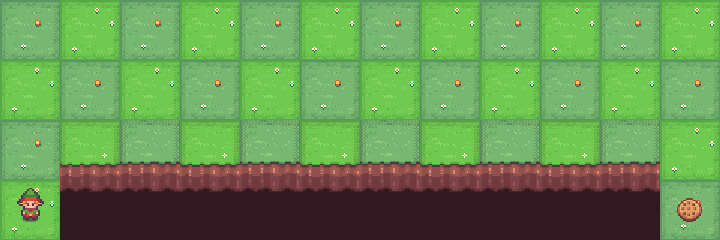

In [27]:
# Display test result animation
from IPython.display import Image
Image('test.gif')